In [1]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_component import *
from model_utlis import *
from calculate_cluster import *
from draw_cluster import *
from data_processing import *
from logger import *

In [2]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad

data = 'MB'
RNA_data = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/scCAS_220601/SHAREseq_mm10_brain/SHAREseq_mm10_brain_RNA.h5ad')
ATAC_data = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/scCAS_220601/SHAREseq_mm10_brain/SHAREseq_mm10_brain_ATAC.h5ad')

# basic multiVI

In [3]:
from scvi_colab import install
import pandas as pd
install()
import scvi
import sys
from calculate_cluster import *
import scipy.sparse as sp
from split_datasets import *

                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
Global seed set to 0


In [4]:
adata = ad.AnnData(sp.hstack((RNA_data.X, ATAC_data.X)))
adata.X = adata.X.tocsr()
adata.obs = RNA_data.obs

m = len(RNA_data.var.index)
n = len(ATAC_data.var.index)
adata.var.index = pd.Series([RNA_data.var.index[i] if i<m else ATAC_data.var.index[i-m] for i in range(m+n)], dtype='object')
adata.var['modality'] = pd.Series(['Gene Expression' if i<m else 'Peaks' for i in range(m+n)], dtype='object').values

adata.var_names_make_unique()

adata_mvi = scvi.data.organize_multiome_anndatas(adata)

adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()

sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality')

mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)

In [5]:
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3293  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 27700 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [6]:
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 343/500:  69%|██████████████████████████████████████████████████████████████████████▋                                | 343/500 [11:47<05:23,  2.06s/it, loss=3.13e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 6938.975. Signaling Trainer to stop.


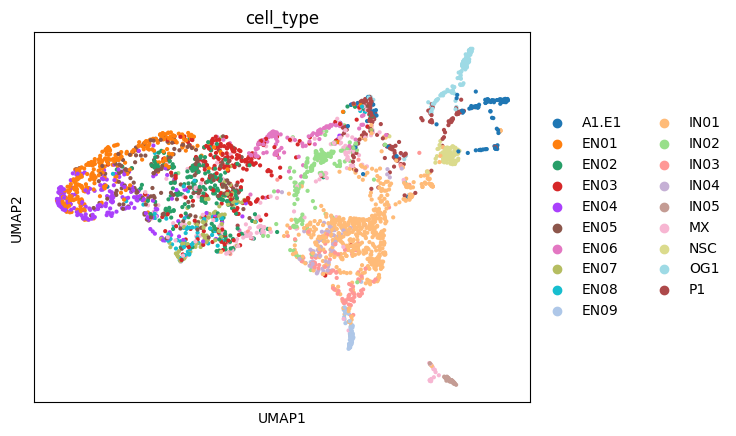

In [7]:
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color='cell_type', title='cell_type')

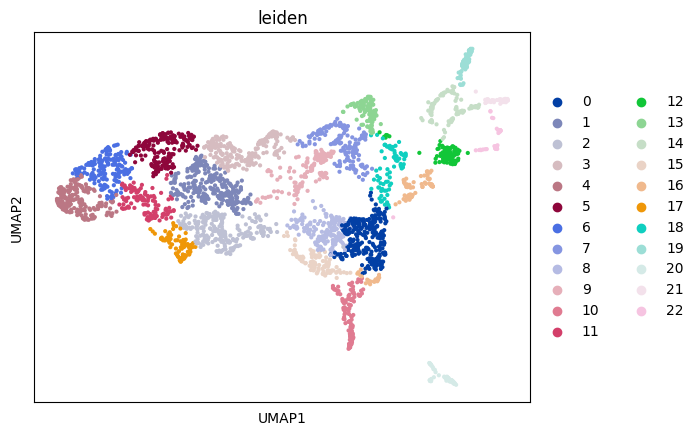

In [8]:
sc.tl.leiden(adata_mvi)
sc.pl.umap(adata_mvi, color='leiden', title='leiden')

In [4]:
import scanpy as sc
import anndata as ad
import episcanpy as epi
import sklearn
from sklearn import metrics


def calculate_cluster_index(adata):
    """
    Evaluation of cluster index of prediction. 
    Cluster method have two types:  Leiden
                         Louvain. 
    Index have eight types:   Adjusted Rand Index
                      Rand Index
                      Normalized Mutual Information
                      Adjusted Mutual Information
                      Homogeneity
                      Completeness
                      V-measure
                      Fowlkes-Mallows Scores
    
    Parameters
    ----------
    adata
        Anndata need to calculate, it's worth noting that there should be 'cell_type' in adata.obs.
        
    """  
    sc.tl.leiden(adata)

    ARI_leiden = metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden'])
    AMI_leiden = metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    NMI_leiden = metrics.normalized_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    HOM_leiden = metrics.homogeneity_score(adata.obs['cell_type'], adata.obs['leiden'])
    COM_leiden = metrics.completeness_score(adata.obs['cell_type'], adata.obs['leiden'])
    V_measure_leiden = metrics.v_measure_score(adata.obs['cell_type'], adata.obs['leiden'])
    
    return ARI_leiden, AMI_leiden, NMI_leiden, HOM_leiden, COM_leiden, V_measure_leiden

In [10]:
calculate_cluster_index(adata_mvi)

(0.31143019208208483,
 0.5369211806011043,
 0.547149529043502,
 0.5744542996220608,
 0.5223226621086695,
 0.547149529043502)

# our predict

In [5]:
file_path = '/home/atac2rna/data/atac2rna/model_output/22_10_12/multiVI_use_prediction/temp'

In [6]:
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
    )
ATAC_data, divide_title, multiply_title, max_temp = ATAC_data_preprocessing(
    ATAC_data,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
)
R2A_predict = []
A2R_predict = []
test_id_a = [i for i in range(RNA_data.X.shape[0])]
test_id_r = [i for i in range(RNA_data.X.shape[0])]

# Part 3 calculate chrom list
chrom_list = []
last_one = ''
for i in range(len(ATAC_data.var.peak)):
    temp = ATAC_data.var.peak[i].split('_')[0]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1

from train_model import Model
import torch
import torch.nn as nn

RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ATAC_input_dim = ATAC_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

############################################################
# Part 4 construct model
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 32 * len(chrom_list), 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 32 * len(chrom_list), ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Sigmoid()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.3,
    chrom_list = chrom_list,
    logging_path = file_path,
    RNA_data = RNA_data,
    ATAC_data = ATAC_data
)

model_path = "/home/atac2rna/data/atac2rna/model_output/22_10_12/multiVI_use_prediction/"+str(data)+"/1"
load_model = True
output_path = file_path
test_evaluate = False
test_cluster = True
test_umap = True
output_data = False

if load_model:
    model.RNA_encoder.load_state_dict(torch.load(model_path + '/model/RNA_encoder.pt'))
    model.ATAC_encoder.load_state_dict(torch.load(model_path + '/model/ATAC_encoder.pt'))
    model.RNA_decoder.load_state_dict(torch.load(model_path + '/model/RNA_decoder.pt'))
    model.ATAC_decoder.load_state_dict(torch.load(model_path + '/model/ATAC_decoder.pt'))
    model.translator.load_state_dict(torch.load(model_path + '/model/translator.pt'))

""" load data """
RNA_input_dim = model.RNA_data.shape[1]
ATAC_input_dim = model.ATAC_data.shape[1]

model.R_test_dataset = Single_omics_dataset(model.RNA_data, test_id_r)
model.A_test_dataset = Single_omics_dataset(model.ATAC_data, test_id_a)
model.R_test_dataloader = DataLoader(model.R_test_dataset, batch_size=100, shuffle=False, num_workers=4)
model.A_test_dataloader = DataLoader(model.A_test_dataset, batch_size=100, shuffle=False, num_workers=4)

model.set_eval()

""" record the predicted data """
with torch.no_grad():
    with tqdm(total = len(model.A_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('ATAC to RNA predicting...')
        for idx, batch_samples in enumerate(model.A_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            A2 = model.ATAC_encoder(batch_samples)
            A2R, A2A, mu_a, sigma_a = model.translator.test_model(A2, 'ATAC')
            A2R = model.RNA_decoder(A2R)

            A2R_predict.append(A2R.cpu())                       

            time.sleep(0.01)
            pbar.update(1)

with torch.no_grad():
    with tqdm(total = len(model.R_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('RNA to ATAC predicting...')
        for idx, batch_samples in enumerate(model.R_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            R2 = model.RNA_encoder(batch_samples)
            R2R, R2A, mu_r, sigma_r = model.translator.test_model(R2, 'RNA')
            R2A = model.ATAC_decoder(R2A)

            R2A_predict.append(R2A.cpu())                       

            time.sleep(0.01)
            pbar.update(1)


1
2
3


RNA to ATAC predicting...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 31.88it/s]


In [7]:
A2R_predict = tensor2adata(A2R_predict)
A2R_predict.obs = RNA_data.obs.iloc[test_id_r, :]
A2R_predict.var = RNA_data.var

R2A_predict = tensor2adata(R2A_predict)
R2A_predict.obs = ATAC_data.obs.iloc[test_id_r, :]
R2A_predict.var = ATAC_data.var

In [8]:
R2A_predict.X = inverse_TFIDF(R2A_predict.X, divide_title[:, test_id_a], multiply_title[:, test_id_a], max_temp)
R2A_predict.X[R2A_predict.X > np.mean(R2A_predict.X, axis=1)] = 1
R2A_predict.X[R2A_predict.X < np.mean(R2A_predict.X, axis=1)] = 0

In [9]:
del divide_title, multiply_title
import gc
gc.collect()

32

In [10]:
adata = ad.AnnData(sp.hstack((A2R_predict.X, R2A_predict.X)))
adata.X = adata.X.tocsr()
adata.obs = A2R_predict.obs

m = len(A2R_predict.var.index)
n = len(R2A_predict.var.index)
adata.var.index = pd.Series([A2R_predict.var.index[i] if i<m else R2A_predict.var.index[i-m] for i in range(m+n)], dtype='object')
adata.var['modality'] = pd.Series(['Gene Expression' if i<m else 'Peaks' for i in range(m+n)], dtype='object').values

adata.var_names_make_unique()

adata = scvi.data.organize_multiome_anndatas(adata)

adata = adata[:, adata.var["modality"].argsort()].copy()

scvi.model.MULTIVI.setup_anndata(adata, batch_key='modality')

mvi = scvi.model.MULTIVI(
    adata,
    n_genes=(adata.var['modality']=='Gene Expression').sum(),
    n_regions=(adata.var['modality']=='Peaks').sum(),
)

In [11]:
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3293  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 40918 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [12]:
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 1/500:   0%|                                                                                                                                                                          | 0/500 [00:00<?, ?it/s]

Epoch 2/500:   0%|▎                                                                                                                                         | 1/500 [00:01<09:52,  1.19s/it, loss=1.26e+04, v_num=1]

Epoch 3/500:   0%|▌                                                                                                                                         | 2/500 [00:02<09:49,  1.18s/it, loss=1.19e+04, v_num=1]

Epoch 4/500:   1%|▊                                                                                                                                         | 3/500 [00:03<09:45,  1.18s/it, loss=1.14e+04, v_num=1]

Epoch 5/500:   1%|█                                                                                                                                         | 4/500 [00:04<09:44,  1.18s/it, loss=1.09e+04, v_num=1]

Epoch 6/500:   1%|█▍                                                                                                                                        | 5/500 [00:05<09:40,  1.17s/it, loss=1.06e+04, v_num=1]

Epoch 7/500:   1%|█▋                                                                                                                                        | 6/500 [00:07<09:37,  1.17s/it, loss=1.03e+04, v_num=1]

Epoch 8/500:   1%|█▉                                                                                                                                        | 7/500 [00:08<09:35,  1.17s/it, loss=1.02e+04, v_num=1]

Epoch 9/500:   2%|██▎                                                                                                                                          | 8/500 [00:09<09:38,  1.18s/it, loss=1e+04, v_num=1]

Epoch 10/500:   2%|██▍                                                                                                                                      | 9/500 [00:10<09:36,  1.17s/it, loss=9.85e+03, v_num=1]

Epoch 11/500:   2%|██▋                                                                                                                                     | 10/500 [00:11<09:33,  1.17s/it, loss=9.76e+03, v_num=1]

Epoch 12/500:   2%|███                                                                                                                                      | 11/500 [00:12<09:31,  1.17s/it, loss=9.6e+03, v_num=1]

Epoch 13/500:   2%|███▎                                                                                                                                    | 12/500 [00:14<09:31,  1.17s/it, loss=9.38e+03, v_num=1]

Epoch 14/500:   3%|███▌                                                                                                                                    | 13/500 [00:15<09:29,  1.17s/it, loss=9.23e+03, v_num=1]

Epoch 15/500:   3%|███▊                                                                                                                                    | 14/500 [00:16<09:27,  1.17s/it, loss=9.18e+03, v_num=1]

Epoch 16/500:   3%|████                                                                                                                                    | 15/500 [00:17<09:26,  1.17s/it, loss=9.04e+03, v_num=1]

Epoch 17/500:   3%|████▎                                                                                                                                   | 16/500 [00:18<09:21,  1.16s/it, loss=9.01e+03, v_num=1]

Epoch 18/500:   3%|████▌                                                                                                                                   | 17/500 [00:19<09:21,  1.16s/it, loss=8.88e+03, v_num=1]

Epoch 19/500:   4%|████▉                                                                                                                                   | 18/500 [00:20<09:09,  1.14s/it, loss=8.83e+03, v_num=1]

Epoch 20/500:   4%|█████▏                                                                                                                                  | 19/500 [00:22<09:11,  1.15s/it, loss=8.81e+03, v_num=1]

Epoch 21/500:   4%|█████▍                                                                                                                                  | 20/500 [00:23<09:16,  1.16s/it, loss=8.73e+03, v_num=1]

Epoch 22/500:   4%|█████▋                                                                                                                                  | 21/500 [00:24<09:15,  1.16s/it, loss=8.68e+03, v_num=1]

Epoch 23/500:   4%|█████▉                                                                                                                                  | 22/500 [00:25<09:14,  1.16s/it, loss=8.59e+03, v_num=1]

Epoch 24/500:   5%|██████▎                                                                                                                                 | 23/500 [00:26<09:18,  1.17s/it, loss=8.54e+03, v_num=1]

Epoch 25/500:   5%|██████▌                                                                                                                                 | 24/500 [00:28<09:17,  1.17s/it, loss=8.43e+03, v_num=1]

Epoch 26/500:   5%|██████▊                                                                                                                                 | 25/500 [00:29<09:16,  1.17s/it, loss=8.39e+03, v_num=1]

Epoch 27/500:   5%|███████                                                                                                                                  | 26/500 [00:30<09:17,  1.18s/it, loss=8.3e+03, v_num=1]

Epoch 28/500:   5%|███████▎                                                                                                                                | 27/500 [00:31<09:14,  1.17s/it, loss=8.31e+03, v_num=1]

Epoch 29/500:   6%|███████▌                                                                                                                                | 28/500 [00:32<09:14,  1.17s/it, loss=8.26e+03, v_num=1]

Epoch 30/500:   6%|███████▉                                                                                                                                 | 29/500 [00:33<09:15,  1.18s/it, loss=8.2e+03, v_num=1]

Epoch 31/500:   6%|████████▏                                                                                                                               | 30/500 [00:35<09:17,  1.19s/it, loss=8.14e+03, v_num=1]

Epoch 32/500:   6%|████████▍                                                                                                                               | 31/500 [00:36<09:16,  1.19s/it, loss=8.03e+03, v_num=1]

Epoch 33/500:   6%|████████▋                                                                                                                               | 32/500 [00:37<09:16,  1.19s/it, loss=7.97e+03, v_num=1]

Epoch 34/500:   7%|████████▉                                                                                                                               | 33/500 [00:38<09:15,  1.19s/it, loss=7.87e+03, v_num=1]

Epoch 35/500:   7%|█████████▏                                                                                                                              | 34/500 [00:39<09:16,  1.19s/it, loss=7.79e+03, v_num=1]

Epoch 36/500:   7%|█████████▌                                                                                                                              | 35/500 [00:41<09:16,  1.20s/it, loss=7.71e+03, v_num=1]

Epoch 37/500:   7%|█████████▊                                                                                                                              | 36/500 [00:42<09:12,  1.19s/it, loss=7.63e+03, v_num=1]

Epoch 38/500:   7%|██████████                                                                                                                              | 37/500 [00:43<09:13,  1.20s/it, loss=7.57e+03, v_num=1]

Epoch 39/500:   8%|██████████▎                                                                                                                             | 38/500 [00:44<09:13,  1.20s/it, loss=7.48e+03, v_num=1]

Epoch 40/500:   8%|██████████▌                                                                                                                             | 39/500 [00:45<09:09,  1.19s/it, loss=7.38e+03, v_num=1]

Epoch 41/500:   8%|██████████▉                                                                                                                             | 40/500 [00:47<09:09,  1.19s/it, loss=7.38e+03, v_num=1]

Epoch 42/500:   8%|███████████▏                                                                                                                             | 41/500 [00:48<09:03,  1.18s/it, loss=7.3e+03, v_num=1]

Epoch 43/500:   8%|███████████▍                                                                                                                            | 42/500 [00:49<09:08,  1.20s/it, loss=7.22e+03, v_num=1]

Epoch 44/500:   9%|███████████▊                                                                                                                             | 43/500 [00:50<09:22,  1.23s/it, loss=7.2e+03, v_num=1]

Epoch 45/500:   9%|███████████▉                                                                                                                            | 44/500 [00:51<09:16,  1.22s/it, loss=7.11e+03, v_num=1]

Epoch 46/500:   9%|████████████▏                                                                                                                           | 45/500 [00:53<09:11,  1.21s/it, loss=7.07e+03, v_num=1]

Epoch 47/500:   9%|████████████▌                                                                                                                           | 46/500 [00:54<09:08,  1.21s/it, loss=7.02e+03, v_num=1]

Epoch 48/500:   9%|████████████▊                                                                                                                           | 47/500 [00:55<09:01,  1.20s/it, loss=6.96e+03, v_num=1]

Epoch 49/500:  10%|█████████████                                                                                                                           | 48/500 [00:56<08:55,  1.18s/it, loss=6.89e+03, v_num=1]

Epoch 50/500:  10%|█████████████▎                                                                                                                          | 49/500 [00:57<08:52,  1.18s/it, loss=6.88e+03, v_num=1]

Epoch 51/500:  10%|█████████████▌                                                                                                                          | 50/500 [00:59<08:49,  1.18s/it, loss=6.82e+03, v_num=1]

Epoch 52/500:  10%|█████████████▉                                                                                                                           | 51/500 [01:00<08:36,  1.15s/it, loss=6.8e+03, v_num=1]

Epoch 53/500:  10%|██████████████▏                                                                                                                         | 52/500 [01:01<08:14,  1.10s/it, loss=6.74e+03, v_num=1]

Epoch 54/500:  11%|██████████████▍                                                                                                                         | 53/500 [01:02<07:52,  1.06s/it, loss=6.74e+03, v_num=1]

Epoch 55/500:  11%|██████████████▋                                                                                                                         | 54/500 [01:02<07:38,  1.03s/it, loss=6.65e+03, v_num=1]

Epoch 56/500:  11%|██████████████▉                                                                                                                         | 55/500 [01:04<07:58,  1.08s/it, loss=6.65e+03, v_num=1]

Epoch 57/500:  11%|███████████████▏                                                                                                                        | 56/500 [01:05<08:10,  1.11s/it, loss=6.61e+03, v_num=1]

Epoch 58/500:  11%|███████████████▌                                                                                                                        | 57/500 [01:06<08:21,  1.13s/it, loss=6.59e+03, v_num=1]

Epoch 59/500:  12%|███████████████▊                                                                                                                        | 58/500 [01:07<08:25,  1.14s/it, loss=6.53e+03, v_num=1]

Epoch 60/500:  12%|████████████████                                                                                                                        | 59/500 [01:08<08:24,  1.14s/it, loss=6.46e+03, v_num=1]

Epoch 61/500:  12%|████████████████▎                                                                                                                       | 60/500 [01:10<08:26,  1.15s/it, loss=6.45e+03, v_num=1]

Epoch 62/500:  12%|████████████████▌                                                                                                                       | 61/500 [01:11<08:27,  1.16s/it, loss=6.44e+03, v_num=1]

Epoch 63/500:  12%|████████████████▊                                                                                                                       | 62/500 [01:12<08:25,  1.15s/it, loss=6.38e+03, v_num=1]

Epoch 64/500:  13%|█████████████████▏                                                                                                                      | 63/500 [01:13<08:21,  1.15s/it, loss=6.36e+03, v_num=1]

Epoch 65/500:  13%|█████████████████▍                                                                                                                      | 64/500 [01:14<08:19,  1.15s/it, loss=6.29e+03, v_num=1]

Epoch 66/500:  13%|█████████████████▋                                                                                                                      | 65/500 [01:15<08:19,  1.15s/it, loss=6.29e+03, v_num=1]

Epoch 67/500:  13%|█████████████████▉                                                                                                                      | 66/500 [01:16<08:20,  1.15s/it, loss=6.24e+03, v_num=1]

Epoch 68/500:  13%|██████████████████▏                                                                                                                     | 67/500 [01:18<08:19,  1.15s/it, loss=6.23e+03, v_num=1]

Epoch 69/500:  14%|██████████████████▍                                                                                                                     | 68/500 [01:19<08:15,  1.15s/it, loss=6.19e+03, v_num=1]

Epoch 70/500:  14%|██████████████████▊                                                                                                                     | 69/500 [01:20<08:13,  1.14s/it, loss=6.15e+03, v_num=1]

Epoch 71/500:  14%|███████████████████                                                                                                                     | 70/500 [01:21<07:52,  1.10s/it, loss=6.13e+03, v_num=1]

Epoch 72/500:  14%|███████████████████▎                                                                                                                    | 71/500 [01:22<07:56,  1.11s/it, loss=6.09e+03, v_num=1]

Epoch 73/500:  14%|███████████████████▌                                                                                                                    | 72/500 [01:23<07:59,  1.12s/it, loss=6.09e+03, v_num=1]

Epoch 74/500:  15%|███████████████████▊                                                                                                                    | 73/500 [01:24<08:08,  1.14s/it, loss=6.03e+03, v_num=1]

Epoch 75/500:  15%|████████████████████▌                                                                                                                      | 74/500 [01:25<08:07,  1.14s/it, loss=6e+03, v_num=1]

Epoch 76/500:  15%|████████████████████▍                                                                                                                   | 75/500 [01:27<08:06,  1.15s/it, loss=5.98e+03, v_num=1]

Epoch 77/500:  15%|████████████████████▋                                                                                                                   | 76/500 [01:28<08:04,  1.14s/it, loss=5.96e+03, v_num=1]

Epoch 78/500:  15%|████████████████████▉                                                                                                                   | 77/500 [01:29<08:03,  1.14s/it, loss=5.96e+03, v_num=1]

Epoch 79/500:  16%|█████████████████████▎                                                                                                                   | 78/500 [01:30<08:03,  1.15s/it, loss=5.9e+03, v_num=1]

Epoch 80/500:  16%|█████████████████████▍                                                                                                                  | 79/500 [01:31<08:02,  1.15s/it, loss=5.88e+03, v_num=1]

Epoch 81/500:  16%|█████████████████████▊                                                                                                                  | 80/500 [01:32<08:01,  1.15s/it, loss=5.87e+03, v_num=1]

Epoch 82/500:  16%|██████████████████████                                                                                                                  | 81/500 [01:34<08:00,  1.15s/it, loss=5.86e+03, v_num=1]

Epoch 83/500:  16%|██████████████████████▎                                                                                                                 | 82/500 [01:35<07:57,  1.14s/it, loss=5.81e+03, v_num=1]

Epoch 84/500:  17%|██████████████████████▌                                                                                                                 | 83/500 [01:36<07:57,  1.14s/it, loss=5.81e+03, v_num=1]

Epoch 85/500:  17%|██████████████████████▊                                                                                                                 | 84/500 [01:37<07:58,  1.15s/it, loss=5.78e+03, v_num=1]

Epoch 86/500:  17%|███████████████████████                                                                                                                 | 85/500 [01:38<07:56,  1.15s/it, loss=5.75e+03, v_num=1]

Epoch 87/500:  17%|███████████████████████▍                                                                                                                | 86/500 [01:39<07:54,  1.15s/it, loss=5.71e+03, v_num=1]

Epoch 88/500:  17%|███████████████████████▊                                                                                                                 | 87/500 [01:40<07:54,  1.15s/it, loss=5.7e+03, v_num=1]

Epoch 89/500:  18%|███████████████████████▉                                                                                                                | 88/500 [01:42<07:55,  1.15s/it, loss=5.68e+03, v_num=1]

Epoch 90/500:  18%|████████████████████████▏                                                                                                               | 89/500 [01:43<07:53,  1.15s/it, loss=5.65e+03, v_num=1]

Epoch 91/500:  18%|████████████████████████▍                                                                                                               | 90/500 [01:44<07:51,  1.15s/it, loss=5.63e+03, v_num=1]

Epoch 92/500:  18%|████████████████████████▊                                                                                                               | 91/500 [01:45<07:48,  1.15s/it, loss=5.62e+03, v_num=1]

Epoch 93/500:  18%|█████████████████████████                                                                                                               | 92/500 [01:46<07:49,  1.15s/it, loss=5.59e+03, v_num=1]

Epoch 94/500:  19%|█████████████████████████▎                                                                                                              | 93/500 [01:47<07:47,  1.15s/it, loss=5.58e+03, v_num=1]

Epoch 95/500:  19%|█████████████████████████▌                                                                                                              | 94/500 [01:48<07:45,  1.15s/it, loss=5.55e+03, v_num=1]

Epoch 96/500:  19%|█████████████████████████▊                                                                                                              | 95/500 [01:50<07:43,  1.14s/it, loss=5.52e+03, v_num=1]

Epoch 97/500:  19%|██████████████████████████                                                                                                              | 96/500 [01:51<07:41,  1.14s/it, loss=5.52e+03, v_num=1]

Epoch 98/500:  19%|██████████████████████████▍                                                                                                             | 97/500 [01:52<07:37,  1.14s/it, loss=5.49e+03, v_num=1]

Epoch 99/500:  20%|██████████████████████████▋                                                                                                             | 98/500 [01:53<07:37,  1.14s/it, loss=5.46e+03, v_num=1]

Epoch 100/500:  20%|██████████████████████████▋                                                                                                            | 99/500 [01:54<07:36,  1.14s/it, loss=5.45e+03, v_num=1]

Epoch 101/500:  20%|██████████████████████████▊                                                                                                           | 100/500 [01:55<07:36,  1.14s/it, loss=5.45e+03, v_num=1]

Epoch 102/500:  20%|███████████████████████████                                                                                                           | 101/500 [01:56<07:38,  1.15s/it, loss=5.41e+03, v_num=1]

Epoch 103/500:  20%|███████████████████████████▎                                                                                                          | 102/500 [01:58<07:41,  1.16s/it, loss=5.39e+03, v_num=1]

Epoch 104/500:  21%|███████████████████████████▌                                                                                                          | 103/500 [01:59<07:43,  1.17s/it, loss=5.39e+03, v_num=1]

Epoch 105/500:  21%|███████████████████████████▊                                                                                                          | 104/500 [02:00<07:43,  1.17s/it, loss=5.35e+03, v_num=1]

Epoch 106/500:  21%|████████████████████████████▏                                                                                                         | 105/500 [02:01<07:40,  1.16s/it, loss=5.38e+03, v_num=1]

Epoch 107/500:  21%|████████████████████████████▍                                                                                                         | 106/500 [02:02<07:37,  1.16s/it, loss=5.34e+03, v_num=1]

Epoch 108/500:  21%|████████████████████████████▉                                                                                                          | 107/500 [02:03<07:33,  1.15s/it, loss=5.3e+03, v_num=1]

Epoch 109/500:  22%|████████████████████████████▉                                                                                                         | 108/500 [02:05<07:30,  1.15s/it, loss=5.27e+03, v_num=1]

Epoch 110/500:  22%|█████████████████████████████▏                                                                                                        | 109/500 [02:06<07:29,  1.15s/it, loss=5.29e+03, v_num=1]

Epoch 111/500:  22%|█████████████████████████████▍                                                                                                        | 110/500 [02:07<07:29,  1.15s/it, loss=5.25e+03, v_num=1]

Epoch 112/500:  22%|█████████████████████████████▋                                                                                                        | 111/500 [02:08<07:29,  1.15s/it, loss=5.25e+03, v_num=1]

Epoch 113/500:  22%|██████████████████████████████                                                                                                        | 112/500 [02:09<07:27,  1.15s/it, loss=5.24e+03, v_num=1]

Epoch 114/500:  23%|██████████████████████████████▎                                                                                                       | 113/500 [02:10<07:23,  1.15s/it, loss=5.22e+03, v_num=1]

Epoch 115/500:  23%|██████████████████████████████▊                                                                                                        | 114/500 [02:11<07:25,  1.15s/it, loss=5.2e+03, v_num=1]

Epoch 116/500:  23%|██████████████████████████████▊                                                                                                       | 115/500 [02:13<07:22,  1.15s/it, loss=5.17e+03, v_num=1]

Epoch 117/500:  23%|███████████████████████████████                                                                                                       | 116/500 [02:14<07:19,  1.14s/it, loss=5.16e+03, v_num=1]

Epoch 118/500:  23%|███████████████████████████████▎                                                                                                      | 117/500 [02:15<07:15,  1.14s/it, loss=5.15e+03, v_num=1]

Epoch 119/500:  24%|███████████████████████████████▌                                                                                                      | 118/500 [02:16<07:11,  1.13s/it, loss=5.13e+03, v_num=1]

Epoch 120/500:  24%|███████████████████████████████▉                                                                                                      | 119/500 [02:17<07:08,  1.12s/it, loss=5.13e+03, v_num=1]

Epoch 121/500:  24%|████████████████████████████████▏                                                                                                     | 120/500 [02:18<07:06,  1.12s/it, loss=5.11e+03, v_num=1]

Epoch 122/500:  24%|████████████████████████████████▍                                                                                                     | 121/500 [02:19<07:05,  1.12s/it, loss=5.11e+03, v_num=1]

Epoch 123/500:  24%|████████████████████████████████▋                                                                                                     | 122/500 [02:20<07:02,  1.12s/it, loss=5.06e+03, v_num=1]

Epoch 124/500:  25%|████████████████████████████████▉                                                                                                     | 123/500 [02:22<07:00,  1.12s/it, loss=5.06e+03, v_num=1]

Epoch 125/500:  25%|█████████████████████████████████▏                                                                                                    | 124/500 [02:23<06:57,  1.11s/it, loss=5.04e+03, v_num=1]

Epoch 126/500:  25%|█████████████████████████████████▌                                                                                                    | 125/500 [02:24<06:54,  1.11s/it, loss=5.04e+03, v_num=1]

Epoch 127/500:  25%|█████████████████████████████████▊                                                                                                    | 126/500 [02:25<06:53,  1.11s/it, loss=5.03e+03, v_num=1]

Epoch 128/500:  25%|██████████████████████████████████▊                                                                                                      | 127/500 [02:26<06:52,  1.11s/it, loss=5e+03, v_num=1]

Epoch 129/500:  26%|██████████████████████████████████▎                                                                                                   | 128/500 [02:27<06:51,  1.11s/it, loss=5.01e+03, v_num=1]

Epoch 130/500:  26%|██████████████████████████████████▌                                                                                                   | 129/500 [02:28<06:47,  1.10s/it, loss=4.96e+03, v_num=1]

Epoch 131/500:  26%|██████████████████████████████████▊                                                                                                   | 130/500 [02:29<06:48,  1.10s/it, loss=4.97e+03, v_num=1]

Epoch 132/500:  26%|███████████████████████████████████                                                                                                   | 131/500 [02:30<06:49,  1.11s/it, loss=4.95e+03, v_num=1]

Epoch 133/500:  26%|███████████████████████████████████▍                                                                                                  | 132/500 [02:32<06:54,  1.13s/it, loss=4.95e+03, v_num=1]

Epoch 134/500:  27%|███████████████████████████████████▋                                                                                                  | 133/500 [02:33<06:56,  1.13s/it, loss=4.91e+03, v_num=1]

Epoch 135/500:  27%|███████████████████████████████████▉                                                                                                  | 134/500 [02:34<07:00,  1.15s/it, loss=4.92e+03, v_num=1]

Epoch 136/500:  27%|████████████████████████████████████▏                                                                                                 | 135/500 [02:35<06:59,  1.15s/it, loss=4.91e+03, v_num=1]

Epoch 137/500:  27%|████████████████████████████████████▍                                                                                                 | 136/500 [02:36<06:59,  1.15s/it, loss=4.89e+03, v_num=1]

Epoch 138/500:  27%|████████████████████████████████████▋                                                                                                 | 137/500 [02:37<06:59,  1.16s/it, loss=4.89e+03, v_num=1]

Epoch 139/500:  28%|████████████████████████████████████▉                                                                                                 | 138/500 [02:39<06:58,  1.16s/it, loss=4.87e+03, v_num=1]

Epoch 140/500:  28%|█████████████████████████████████████▎                                                                                                | 139/500 [02:40<06:58,  1.16s/it, loss=4.84e+03, v_num=1]

Epoch 141/500:  28%|█████████████████████████████████████▌                                                                                                | 140/500 [02:41<06:56,  1.16s/it, loss=4.84e+03, v_num=1]

Epoch 142/500:  28%|█████████████████████████████████████▊                                                                                                | 141/500 [02:42<06:56,  1.16s/it, loss=4.84e+03, v_num=1]

Epoch 143/500:  28%|██████████████████████████████████████                                                                                                | 142/500 [02:43<06:54,  1.16s/it, loss=4.83e+03, v_num=1]

Epoch 144/500:  29%|██████████████████████████████████████▎                                                                                               | 143/500 [02:44<06:52,  1.16s/it, loss=4.78e+03, v_num=1]

Epoch 145/500:  29%|██████████████████████████████████████▌                                                                                               | 144/500 [02:45<06:49,  1.15s/it, loss=4.79e+03, v_num=1]

Epoch 146/500:  29%|███████████████████████████████████████▏                                                                                               | 145/500 [02:47<06:46,  1.15s/it, loss=4.8e+03, v_num=1]

Epoch 147/500:  29%|███████████████████████████████████████▏                                                                                              | 146/500 [02:48<06:44,  1.14s/it, loss=4.78e+03, v_num=1]

Epoch 148/500:  29%|███████████████████████████████████████▍                                                                                              | 147/500 [02:49<06:42,  1.14s/it, loss=4.75e+03, v_num=1]

Epoch 149/500:  30%|███████████████████████████████████████▋                                                                                              | 148/500 [02:50<06:39,  1.13s/it, loss=4.78e+03, v_num=1]

Epoch 150/500:  30%|███████████████████████████████████████▉                                                                                              | 149/500 [02:51<06:37,  1.13s/it, loss=4.73e+03, v_num=1]

Epoch 151/500:  30%|████████████████████████████████████████▏                                                                                             | 150/500 [02:52<06:35,  1.13s/it, loss=4.72e+03, v_num=1]

Epoch 152/500:  30%|████████████████████████████████████████▍                                                                                             | 151/500 [02:53<06:31,  1.12s/it, loss=4.73e+03, v_num=1]

Epoch 153/500:  30%|████████████████████████████████████████▋                                                                                             | 152/500 [02:54<06:30,  1.12s/it, loss=4.71e+03, v_num=1]

Epoch 154/500:  31%|█████████████████████████████████████████                                                                                             | 153/500 [02:56<06:29,  1.12s/it, loss=4.69e+03, v_num=1]

Epoch 155/500:  31%|█████████████████████████████████████████▎                                                                                            | 154/500 [02:57<06:29,  1.13s/it, loss=4.67e+03, v_num=1]

Epoch 156/500:  31%|█████████████████████████████████████████▌                                                                                            | 155/500 [02:58<06:28,  1.13s/it, loss=4.67e+03, v_num=1]

Epoch 157/500:  31%|█████████████████████████████████████████▊                                                                                            | 156/500 [02:59<06:28,  1.13s/it, loss=4.64e+03, v_num=1]

Epoch 158/500:  31%|██████████████████████████████████████████                                                                                            | 157/500 [03:00<06:25,  1.12s/it, loss=4.63e+03, v_num=1]

Epoch 159/500:  32%|██████████████████████████████████████████▎                                                                                           | 158/500 [03:01<06:24,  1.12s/it, loss=4.65e+03, v_num=1]

Epoch 160/500:  32%|██████████████████████████████████████████▌                                                                                           | 159/500 [03:02<06:23,  1.12s/it, loss=4.64e+03, v_num=1]

Epoch 161/500:  32%|██████████████████████████████████████████▉                                                                                           | 160/500 [03:03<06:21,  1.12s/it, loss=4.61e+03, v_num=1]

Epoch 162/500:  32%|███████████████████████████████████████████▍                                                                                           | 161/500 [03:05<06:21,  1.13s/it, loss=4.6e+03, v_num=1]

Epoch 163/500:  32%|███████████████████████████████████████████▍                                                                                          | 162/500 [03:06<06:20,  1.13s/it, loss=4.58e+03, v_num=1]

Epoch 164/500:  33%|███████████████████████████████████████████▋                                                                                          | 163/500 [03:07<06:18,  1.12s/it, loss=4.58e+03, v_num=1]

Epoch 165/500:  33%|███████████████████████████████████████████▉                                                                                          | 164/500 [03:08<06:17,  1.12s/it, loss=4.58e+03, v_num=1]

Epoch 166/500:  33%|████████████████████████████████████████████▏                                                                                         | 165/500 [03:09<06:10,  1.11s/it, loss=4.55e+03, v_num=1]

Epoch 167/500:  33%|████████████████████████████████████████████▍                                                                                         | 166/500 [03:10<06:13,  1.12s/it, loss=4.54e+03, v_num=1]

Epoch 168/500:  33%|████████████████████████████████████████████▊                                                                                         | 167/500 [03:11<06:05,  1.10s/it, loss=4.54e+03, v_num=1]

Epoch 169/500:  34%|█████████████████████████████████████████████                                                                                         | 168/500 [03:12<06:03,  1.09s/it, loss=4.54e+03, v_num=1]

Epoch 170/500:  34%|█████████████████████████████████████████████▎                                                                                        | 169/500 [03:13<06:05,  1.10s/it, loss=4.51e+03, v_num=1]

Epoch 171/500:  34%|█████████████████████████████████████████████▌                                                                                        | 170/500 [03:15<06:10,  1.12s/it, loss=4.51e+03, v_num=1]

Epoch 172/500:  34%|█████████████████████████████████████████████▊                                                                                        | 171/500 [03:16<06:10,  1.12s/it, loss=4.49e+03, v_num=1]

Epoch 173/500:  34%|██████████████████████████████████████████████                                                                                        | 172/500 [03:17<06:11,  1.13s/it, loss=4.49e+03, v_num=1]

Epoch 174/500:  35%|██████████████████████████████████████████████▎                                                                                       | 173/500 [03:18<06:09,  1.13s/it, loss=4.48e+03, v_num=1]

Epoch 175/500:  35%|██████████████████████████████████████████████▋                                                                                       | 174/500 [03:19<06:12,  1.14s/it, loss=4.48e+03, v_num=1]

Epoch 176/500:  35%|██████████████████████████████████████████████▉                                                                                       | 175/500 [03:20<06:14,  1.15s/it, loss=4.45e+03, v_num=1]

Epoch 177/500:  35%|███████████████████████████████████████████████▏                                                                                      | 176/500 [03:21<06:09,  1.14s/it, loss=4.45e+03, v_num=1]

Epoch 178/500:  35%|███████████████████████████████████████████████▍                                                                                      | 177/500 [03:23<06:09,  1.14s/it, loss=4.44e+03, v_num=1]

Epoch 179/500:  36%|███████████████████████████████████████████████▋                                                                                      | 178/500 [03:24<06:06,  1.14s/it, loss=4.44e+03, v_num=1]

Epoch 180/500:  36%|███████████████████████████████████████████████▉                                                                                      | 179/500 [03:25<06:00,  1.12s/it, loss=4.42e+03, v_num=1]

Epoch 181/500:  36%|████████████████████████████████████████████████▌                                                                                      | 180/500 [03:26<06:03,  1.14s/it, loss=4.4e+03, v_num=1]

Epoch 182/500:  36%|████████████████████████████████████████████████▊                                                                                      | 181/500 [03:27<06:03,  1.14s/it, loss=4.4e+03, v_num=1]

Epoch 183/500:  36%|████████████████████████████████████████████████▊                                                                                     | 182/500 [03:28<06:06,  1.15s/it, loss=4.39e+03, v_num=1]

Epoch 184/500:  37%|█████████████████████████████████████████████████▍                                                                                     | 183/500 [03:29<06:06,  1.16s/it, loss=4.4e+03, v_num=1]

Epoch 185/500:  37%|█████████████████████████████████████████████████▎                                                                                    | 184/500 [03:31<06:08,  1.17s/it, loss=4.37e+03, v_num=1]

Epoch 186/500:  37%|█████████████████████████████████████████████████▌                                                                                    | 185/500 [03:32<06:09,  1.17s/it, loss=4.35e+03, v_num=1]

Epoch 187/500:  37%|█████████████████████████████████████████████████▊                                                                                    | 186/500 [03:33<06:10,  1.18s/it, loss=4.35e+03, v_num=1]

Epoch 188/500:  37%|██████████████████████████████████████████████████                                                                                    | 187/500 [03:34<06:11,  1.19s/it, loss=4.34e+03, v_num=1]

Epoch 189/500:  38%|██████████████████████████████████████████████████▍                                                                                   | 188/500 [03:35<06:10,  1.19s/it, loss=4.35e+03, v_num=1]

Epoch 190/500:  38%|██████████████████████████████████████████████████▋                                                                                   | 189/500 [03:37<06:09,  1.19s/it, loss=4.32e+03, v_num=1]

Epoch 191/500:  38%|██████████████████████████████████████████████████▉                                                                                   | 190/500 [03:38<06:08,  1.19s/it, loss=4.33e+03, v_num=1]

Epoch 192/500:  38%|███████████████████████████████████████████████████▌                                                                                   | 191/500 [03:39<06:05,  1.18s/it, loss=4.3e+03, v_num=1]

Epoch 193/500:  38%|███████████████████████████████████████████████████▍                                                                                  | 192/500 [03:40<06:03,  1.18s/it, loss=4.28e+03, v_num=1]

Epoch 194/500:  39%|████████████████████████████████████████████████████                                                                                   | 193/500 [03:41<05:51,  1.15s/it, loss=4.3e+03, v_num=1]

Epoch 195/500:  39%|███████████████████████████████████████████████████▉                                                                                  | 194/500 [03:42<05:48,  1.14s/it, loss=4.27e+03, v_num=1]

Epoch 196/500:  39%|████████████████████████████████████████████████████▎                                                                                 | 195/500 [03:43<05:33,  1.09s/it, loss=4.27e+03, v_num=1]

Epoch 197/500:  39%|████████████████████████████████████████████████████▌                                                                                 | 196/500 [03:44<05:36,  1.11s/it, loss=4.25e+03, v_num=1]

Epoch 198/500:  39%|████████████████████████████████████████████████████▊                                                                                 | 197/500 [03:46<05:38,  1.12s/it, loss=4.25e+03, v_num=1]

Epoch 199/500:  40%|█████████████████████████████████████████████████████                                                                                 | 198/500 [03:47<05:40,  1.13s/it, loss=4.25e+03, v_num=1]

Epoch 200/500:  40%|█████████████████████████████████████████████████████▎                                                                                | 199/500 [03:48<05:41,  1.13s/it, loss=4.25e+03, v_num=1]

Epoch 201/500:  40%|█████████████████████████████████████████████████████▌                                                                                | 200/500 [03:49<05:40,  1.14s/it, loss=4.23e+03, v_num=1]

Epoch 202/500:  40%|██████████████████████████████████████████████████████▎                                                                                | 201/500 [03:50<05:40,  1.14s/it, loss=4.2e+03, v_num=1]

Epoch 203/500:  40%|██████████████████████████████████████████████████████▏                                                                               | 202/500 [03:51<05:39,  1.14s/it, loss=4.21e+03, v_num=1]

Epoch 204/500:  41%|██████████████████████████████████████████████████████▍                                                                               | 203/500 [03:52<05:39,  1.14s/it, loss=4.22e+03, v_num=1]

Epoch 205/500:  41%|██████████████████████████████████████████████████████▋                                                                               | 204/500 [03:54<05:38,  1.14s/it, loss=4.17e+03, v_num=1]

Epoch 206/500:  41%|██████████████████████████████████████████████████████▉                                                                               | 205/500 [03:55<05:36,  1.14s/it, loss=4.19e+03, v_num=1]

Epoch 207/500:  41%|███████████████████████████████████████████████████████▏                                                                              | 206/500 [03:56<05:37,  1.15s/it, loss=4.18e+03, v_num=1]

Epoch 208/500:  41%|███████████████████████████████████████████████████████▍                                                                              | 207/500 [03:57<05:32,  1.13s/it, loss=4.18e+03, v_num=1]

Epoch 209/500:  42%|███████████████████████████████████████████████████████▋                                                                              | 208/500 [03:58<05:26,  1.12s/it, loss=4.17e+03, v_num=1]

Epoch 210/500:  42%|████████████████████████████████████████████████████████                                                                              | 209/500 [03:59<05:23,  1.11s/it, loss=4.16e+03, v_num=1]

Epoch 211/500:  42%|████████████████████████████████████████████████████████▎                                                                             | 210/500 [04:00<05:20,  1.11s/it, loss=4.15e+03, v_num=1]

Epoch 212/500:  42%|████████████████████████████████████████████████████████▌                                                                             | 211/500 [04:01<05:20,  1.11s/it, loss=4.12e+03, v_num=1]

Epoch 213/500:  42%|████████████████████████████████████████████████████████▊                                                                             | 212/500 [04:03<05:18,  1.11s/it, loss=4.14e+03, v_num=1]

Epoch 214/500:  43%|█████████████████████████████████████████████████████████                                                                             | 213/500 [04:04<05:17,  1.11s/it, loss=4.13e+03, v_num=1]

Epoch 215/500:  43%|█████████████████████████████████████████████████████████▎                                                                            | 214/500 [04:05<05:16,  1.11s/it, loss=4.13e+03, v_num=1]

Epoch 216/500:  43%|█████████████████████████████████████████████████████████▌                                                                            | 215/500 [04:06<05:14,  1.10s/it, loss=4.11e+03, v_num=1]

Epoch 217/500:  43%|█████████████████████████████████████████████████████████▉                                                                            | 216/500 [04:07<05:15,  1.11s/it, loss=4.11e+03, v_num=1]

Epoch 218/500:  43%|██████████████████████████████████████████████████████████▏                                                                           | 217/500 [04:08<05:15,  1.11s/it, loss=4.09e+03, v_num=1]

Epoch 219/500:  44%|██████████████████████████████████████████████████████████▍                                                                           | 218/500 [04:09<05:12,  1.11s/it, loss=4.08e+03, v_num=1]

Epoch 220/500:  44%|██████████████████████████████████████████████████████████▋                                                                           | 219/500 [04:10<05:11,  1.11s/it, loss=4.07e+03, v_num=1]

Epoch 221/500:  44%|██████████████████████████████████████████████████████████▉                                                                           | 220/500 [04:11<05:12,  1.12s/it, loss=4.08e+03, v_num=1]

Epoch 222/500:  44%|███████████████████████████████████████████████████████████▏                                                                          | 221/500 [04:13<05:13,  1.12s/it, loss=4.05e+03, v_num=1]

Epoch 223/500:  44%|███████████████████████████████████████████████████████████▍                                                                          | 222/500 [04:14<05:13,  1.13s/it, loss=4.06e+03, v_num=1]

Epoch 224/500:  45%|███████████████████████████████████████████████████████████▊                                                                          | 223/500 [04:15<05:13,  1.13s/it, loss=4.04e+03, v_num=1]

Epoch 225/500:  45%|████████████████████████████████████████████████████████████                                                                          | 224/500 [04:16<05:13,  1.14s/it, loss=4.01e+03, v_num=1]

Epoch 226/500:  45%|████████████████████████████████████████████████████████████▎                                                                         | 225/500 [04:17<05:14,  1.14s/it, loss=4.01e+03, v_num=1]

Epoch 227/500:  45%|████████████████████████████████████████████████████████████▌                                                                         | 226/500 [04:18<05:13,  1.15s/it, loss=4.02e+03, v_num=1]

Epoch 228/500:  45%|████████████████████████████████████████████████████████████▊                                                                         | 227/500 [04:19<05:13,  1.15s/it, loss=4.01e+03, v_num=1]

Epoch 229/500:  46%|█████████████████████████████████████████████████████████████                                                                         | 228/500 [04:21<05:12,  1.15s/it, loss=3.99e+03, v_num=1]

Epoch 230/500:  46%|█████████████████████████████████████████████████████████████▎                                                                        | 229/500 [04:22<05:11,  1.15s/it, loss=4.01e+03, v_num=1]

Epoch 231/500:  46%|█████████████████████████████████████████████████████████████▋                                                                        | 230/500 [04:23<05:10,  1.15s/it, loss=3.99e+03, v_num=1]

Epoch 232/500:  46%|█████████████████████████████████████████████████████████████▉                                                                        | 231/500 [04:24<05:08,  1.15s/it, loss=3.99e+03, v_num=1]

Epoch 233/500:  46%|██████████████████████████████████████████████████████████████▏                                                                       | 232/500 [04:25<05:07,  1.15s/it, loss=3.95e+03, v_num=1]

Epoch 234/500:  47%|██████████████████████████████████████████████████████████████▍                                                                       | 233/500 [04:26<05:07,  1.15s/it, loss=3.96e+03, v_num=1]

Epoch 235/500:  47%|██████████████████████████████████████████████████████████████▋                                                                       | 234/500 [04:27<05:04,  1.15s/it, loss=3.97e+03, v_num=1]

Epoch 236/500:  47%|██████████████████████████████████████████████████████████████▉                                                                       | 235/500 [04:29<05:02,  1.14s/it, loss=3.96e+03, v_num=1]

Epoch 237/500:  47%|███████████████████████████████████████████████████████████████▏                                                                      | 236/500 [04:30<05:02,  1.15s/it, loss=3.93e+03, v_num=1]

Epoch 238/500:  47%|███████████████████████████████████████████████████████████████▌                                                                      | 237/500 [04:31<05:01,  1.15s/it, loss=3.94e+03, v_num=1]

Epoch 239/500:  48%|███████████████████████████████████████████████████████████████▊                                                                      | 238/500 [04:32<04:58,  1.14s/it, loss=3.93e+03, v_num=1]

Epoch 240/500:  48%|████████████████████████████████████████████████████████████████                                                                      | 239/500 [04:33<04:57,  1.14s/it, loss=3.91e+03, v_num=1]

Epoch 241/500:  48%|████████████████████████████████████████████████████████████████▎                                                                     | 240/500 [04:34<04:56,  1.14s/it, loss=3.91e+03, v_num=1]

Epoch 242/500:  48%|████████████████████████████████████████████████████████████████▌                                                                     | 241/500 [04:35<04:56,  1.14s/it, loss=3.87e+03, v_num=1]

Epoch 243/500:  48%|████████████████████████████████████████████████████████████████▊                                                                     | 242/500 [04:37<04:56,  1.15s/it, loss=3.89e+03, v_num=1]

Epoch 244/500:  49%|█████████████████████████████████████████████████████████████████                                                                     | 243/500 [04:38<04:55,  1.15s/it, loss=3.89e+03, v_num=1]

Epoch 245/500:  49%|█████████████████████████████████████████████████████████████████▉                                                                     | 244/500 [04:39<04:55,  1.15s/it, loss=3.9e+03, v_num=1]

Epoch 246/500:  49%|█████████████████████████████████████████████████████████████████▋                                                                    | 245/500 [04:40<04:53,  1.15s/it, loss=3.87e+03, v_num=1]

Epoch 247/500:  49%|█████████████████████████████████████████████████████████████████▉                                                                    | 246/500 [04:41<04:53,  1.15s/it, loss=3.88e+03, v_num=1]

Epoch 248/500:  49%|██████████████████████████████████████████████████████████████████▏                                                                   | 247/500 [04:42<04:51,  1.15s/it, loss=3.85e+03, v_num=1]

Epoch 249/500:  50%|██████████████████████████████████████████████████████████████████▍                                                                   | 248/500 [04:44<04:49,  1.15s/it, loss=3.89e+03, v_num=1]

Epoch 250/500:  50%|██████████████████████████████████████████████████████████████████▋                                                                   | 249/500 [04:45<04:47,  1.15s/it, loss=3.86e+03, v_num=1]

Epoch 251/500:  50%|███████████████████████████████████████████████████████████████████                                                                   | 250/500 [04:46<04:46,  1.15s/it, loss=3.83e+03, v_num=1]

Epoch 252/500:  50%|███████████████████████████████████████████████████████████████████▎                                                                  | 251/500 [04:47<04:46,  1.15s/it, loss=3.82e+03, v_num=1]

Epoch 253/500:  50%|███████████████████████████████████████████████████████████████████▌                                                                  | 252/500 [04:48<04:36,  1.12s/it, loss=3.84e+03, v_num=1]

Epoch 254/500:  51%|███████████████████████████████████████████████████████████████████▊                                                                  | 253/500 [04:49<04:27,  1.08s/it, loss=3.81e+03, v_num=1]

Epoch 255/500:  51%|████████████████████████████████████████████████████████████████████▌                                                                  | 254/500 [04:50<04:30,  1.10s/it, loss=3.8e+03, v_num=1]

Epoch 256/500:  51%|████████████████████████████████████████████████████████████████████▎                                                                 | 255/500 [04:51<04:33,  1.11s/it, loss=3.79e+03, v_num=1]

Epoch 257/500:  51%|████████████████████████████████████████████████████████████████████▌                                                                 | 256/500 [04:52<04:35,  1.13s/it, loss=3.81e+03, v_num=1]

Epoch 258/500:  51%|████████████████████████████████████████████████████████████████████▉                                                                 | 257/500 [04:54<04:37,  1.14s/it, loss=3.78e+03, v_num=1]

Epoch 259/500:  52%|█████████████████████████████████████████████████████████████████████▏                                                                | 258/500 [04:55<04:33,  1.13s/it, loss=3.79e+03, v_num=1]

Epoch 260/500:  52%|█████████████████████████████████████████████████████████████████████▍                                                                | 259/500 [04:56<04:22,  1.09s/it, loss=3.77e+03, v_num=1]

Epoch 261/500:  52%|█████████████████████████████████████████████████████████████████████▋                                                                | 260/500 [04:57<04:15,  1.07s/it, loss=3.78e+03, v_num=1]

Epoch 262/500:  52%|█████████████████████████████████████████████████████████████████████▉                                                                | 261/500 [04:58<04:20,  1.09s/it, loss=3.77e+03, v_num=1]

Epoch 263/500:  52%|██████████████████████████████████████████████████████████████████████▏                                                               | 262/500 [04:59<04:20,  1.10s/it, loss=3.77e+03, v_num=1]

Epoch 264/500:  53%|██████████████████████████████████████████████████████████████████████▍                                                               | 263/500 [05:00<04:24,  1.12s/it, loss=3.75e+03, v_num=1]

Epoch 265/500:  53%|██████████████████████████████████████████████████████████████████████▊                                                               | 264/500 [05:01<04:26,  1.13s/it, loss=3.76e+03, v_num=1]

Epoch 266/500:  53%|███████████████████████████████████████████████████████████████████████                                                               | 265/500 [05:03<04:27,  1.14s/it, loss=3.73e+03, v_num=1]

Epoch 267/500:  53%|███████████████████████████████████████████████████████████████████████▎                                                              | 266/500 [05:04<04:26,  1.14s/it, loss=3.72e+03, v_num=1]

Epoch 268/500:  53%|███████████████████████████████████████████████████████████████████████▌                                                              | 267/500 [05:05<04:27,  1.15s/it, loss=3.73e+03, v_num=1]

Epoch 269/500:  54%|███████████████████████████████████████████████████████████████████████▊                                                              | 268/500 [05:06<04:26,  1.15s/it, loss=3.73e+03, v_num=1]

Epoch 270/500:  54%|████████████████████████████████████████████████████████████████████████                                                              | 269/500 [05:07<04:26,  1.15s/it, loss=3.71e+03, v_num=1]

Epoch 271/500:  54%|████████████████████████████████████████████████████████████████████████▎                                                             | 270/500 [05:08<04:24,  1.15s/it, loss=3.72e+03, v_num=1]

Epoch 272/500:  54%|████████████████████████████████████████████████████████████████████████▋                                                             | 271/500 [05:09<04:23,  1.15s/it, loss=3.69e+03, v_num=1]

Epoch 273/500:  54%|████████████████████████████████████████████████████████████████████████▉                                                             | 272/500 [05:11<04:22,  1.15s/it, loss=3.69e+03, v_num=1]

Epoch 274/500:  55%|█████████████████████████████████████████████████████████████████████████▏                                                            | 273/500 [05:12<04:23,  1.16s/it, loss=3.68e+03, v_num=1]

Epoch 275/500:  55%|█████████████████████████████████████████████████████████████████████████▍                                                            | 274/500 [05:13<04:22,  1.16s/it, loss=3.68e+03, v_num=1]

Epoch 276/500:  55%|██████████████████████████████████████████████████████████████████████████▎                                                            | 275/500 [05:14<04:22,  1.17s/it, loss=3.7e+03, v_num=1]

Epoch 277/500:  55%|█████████████████████████████████████████████████████████████████████████▉                                                            | 276/500 [05:15<04:21,  1.17s/it, loss=3.69e+03, v_num=1]

Epoch 278/500:  55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 277/500 [05:16<04:19,  1.16s/it, loss=3.66e+03, v_num=1]

Epoch 279/500:  56%|██████████████████████████████████████████████████████████████████████████▌                                                           | 278/500 [05:18<04:18,  1.16s/it, loss=3.65e+03, v_num=1]

Epoch 280/500:  56%|██████████████████████████████████████████████████████████████████████████▊                                                           | 279/500 [05:19<04:18,  1.17s/it, loss=3.66e+03, v_num=1]

Epoch 281/500:  56%|███████████████████████████████████████████████████████████████████████████                                                           | 280/500 [05:20<04:16,  1.16s/it, loss=3.63e+03, v_num=1]

Epoch 282/500:  56%|███████████████████████████████████████████████████████████████████████████▎                                                          | 281/500 [05:21<04:14,  1.16s/it, loss=3.65e+03, v_num=1]

Epoch 283/500:  56%|███████████████████████████████████████████████████████████████████████████▌                                                          | 282/500 [05:22<04:11,  1.15s/it, loss=3.62e+03, v_num=1]

Epoch 284/500:  57%|███████████████████████████████████████████████████████████████████████████▊                                                          | 283/500 [05:23<04:08,  1.14s/it, loss=3.62e+03, v_num=1]

Epoch 285/500:  57%|████████████████████████████████████████████████████████████████████████████                                                          | 284/500 [05:24<04:07,  1.14s/it, loss=3.63e+03, v_num=1]

Epoch 286/500:  57%|████████████████████████████████████████████████████████████████████████████▍                                                         | 285/500 [05:26<04:07,  1.15s/it, loss=3.62e+03, v_num=1]

Epoch 287/500:  57%|█████████████████████████████████████████████████████████████████████████████▏                                                         | 286/500 [05:27<04:04,  1.14s/it, loss=3.6e+03, v_num=1]

Epoch 288/500:  57%|█████████████████████████████████████████████████████████████████████████████▍                                                         | 287/500 [05:28<04:00,  1.13s/it, loss=3.6e+03, v_num=1]

Epoch 289/500:  58%|█████████████████████████████████████████████████████████████████████████████▊                                                         | 288/500 [05:29<03:58,  1.13s/it, loss=3.6e+03, v_num=1]

Epoch 290/500:  58%|█████████████████████████████████████████████████████████████████████████████▍                                                        | 289/500 [05:30<03:54,  1.11s/it, loss=3.59e+03, v_num=1]

Epoch 291/500:  58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 290/500 [05:31<03:55,  1.12s/it, loss=3.58e+03, v_num=1]

Epoch 292/500:  58%|█████████████████████████████████████████████████████████████████████████████▉                                                        | 291/500 [05:32<03:56,  1.13s/it, loss=3.59e+03, v_num=1]

Epoch 293/500:  58%|██████████████████████████████████████████████████████████████████████████████▎                                                       | 292/500 [05:34<03:57,  1.14s/it, loss=3.56e+03, v_num=1]

Epoch 294/500:  59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 293/500 [05:35<03:57,  1.15s/it, loss=3.55e+03, v_num=1]

Epoch 295/500:  59%|██████████████████████████████████████████████████████████████████████████████▊                                                       | 294/500 [05:36<03:56,  1.15s/it, loss=3.56e+03, v_num=1]

Epoch 296/500:  59%|███████████████████████████████████████████████████████████████████████████████                                                       | 295/500 [05:37<03:55,  1.15s/it, loss=3.54e+03, v_num=1]

Epoch 297/500:  59%|███████████████████████████████████████████████████████████████████████████████▎                                                      | 296/500 [05:38<03:55,  1.15s/it, loss=3.53e+03, v_num=1]

Epoch 298/500:  59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 297/500 [05:39<03:49,  1.13s/it, loss=3.56e+03, v_num=1]

Epoch 299/500:  60%|███████████████████████████████████████████████████████████████████████████████▊                                                      | 298/500 [05:40<03:47,  1.13s/it, loss=3.52e+03, v_num=1]

Epoch 300/500:  60%|████████████████████████████████████████████████████████████████████████████████▏                                                     | 299/500 [05:41<03:46,  1.12s/it, loss=3.53e+03, v_num=1]

Epoch 301/500:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 300/500 [05:43<03:46,  1.13s/it, loss=3.51e+03, v_num=1]

Epoch 302/500:  60%|█████████████████████████████████████████████████████████████████████████████████▎                                                     | 301/500 [05:44<03:45,  1.13s/it, loss=3.5e+03, v_num=1]

Epoch 303/500:  60%|█████████████████████████████████████████████████████████████████████████████████▌                                                     | 302/500 [05:45<03:45,  1.14s/it, loss=3.5e+03, v_num=1]

Epoch 304/500:  61%|█████████████████████████████████████████████████████████████████████████████████▏                                                    | 303/500 [05:46<03:45,  1.15s/it, loss=3.51e+03, v_num=1]

Epoch 305/500:  61%|█████████████████████████████████████████████████████████████████████████████████▍                                                    | 304/500 [05:47<03:45,  1.15s/it, loss=3.51e+03, v_num=1]

Epoch 306/500:  61%|█████████████████████████████████████████████████████████████████████████████████▋                                                    | 305/500 [05:48<03:44,  1.15s/it, loss=3.47e+03, v_num=1]

Epoch 307/500:  61%|██████████████████████████████████████████████████████████████████████████████████                                                    | 306/500 [05:50<03:43,  1.15s/it, loss=3.51e+03, v_num=1]

Epoch 308/500:  61%|██████████████████████████████████████████████████████████████████████████████████▎                                                   | 307/500 [05:51<03:42,  1.15s/it, loss=3.47e+03, v_num=1]

Epoch 309/500:  62%|██████████████████████████████████████████████████████████████████████████████████▌                                                   | 308/500 [05:52<03:41,  1.15s/it, loss=3.48e+03, v_num=1]

Epoch 310/500:  62%|██████████████████████████████████████████████████████████████████████████████████▊                                                   | 309/500 [05:53<03:40,  1.15s/it, loss=3.47e+03, v_num=1]

Epoch 311/500:  62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 310/500 [05:54<03:39,  1.16s/it, loss=3.46e+03, v_num=1]

Epoch 312/500:  62%|███████████████████████████████████████████████████████████████████████████████████▎                                                  | 311/500 [05:55<03:37,  1.15s/it, loss=3.46e+03, v_num=1]

Epoch 313/500:  62%|███████████████████████████████████████████████████████████████████████████████████▌                                                  | 312/500 [05:56<03:36,  1.15s/it, loss=3.45e+03, v_num=1]

Epoch 314/500:  63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 313/500 [05:58<03:35,  1.15s/it, loss=3.44e+03, v_num=1]

Epoch 315/500:  63%|████████████████████████████████████████████████████████████████████████████████████▏                                                 | 314/500 [05:59<03:33,  1.15s/it, loss=3.44e+03, v_num=1]

Epoch 316/500:  63%|█████████████████████████████████████████████████████████████████████████████████████                                                  | 315/500 [06:00<03:33,  1.15s/it, loss=3.4e+03, v_num=1]

Epoch 317/500:  63%|████████████████████████████████████████████████████████████████████████████████████▋                                                 | 316/500 [06:01<03:31,  1.15s/it, loss=3.41e+03, v_num=1]

Epoch 318/500:  63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 317/500 [06:02<03:30,  1.15s/it, loss=3.44e+03, v_num=1]

Epoch 319/500:  64%|█████████████████████████████████████████████████████████████████████████████████████▏                                                | 318/500 [06:03<03:30,  1.16s/it, loss=3.43e+03, v_num=1]

Epoch 320/500:  64%|█████████████████████████████████████████████████████████████████████████████████████▍                                                | 319/500 [06:05<03:30,  1.16s/it, loss=3.41e+03, v_num=1]

Epoch 321/500:  64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 320/500 [06:06<03:28,  1.16s/it, loss=3.42e+03, v_num=1]

Epoch 322/500:  64%|██████████████████████████████████████████████████████████████████████████████████████                                                | 321/500 [06:07<03:24,  1.14s/it, loss=3.41e+03, v_num=1]

Epoch 323/500:  64%|██████████████████████████████████████████████████████████████████████████████████████▎                                               | 322/500 [06:08<03:23,  1.15s/it, loss=3.41e+03, v_num=1]

Epoch 324/500:  65%|██████████████████████████████████████████████████████████████████████████████████████▌                                               | 323/500 [06:09<03:23,  1.15s/it, loss=3.39e+03, v_num=1]

Epoch 325/500:  65%|███████████████████████████████████████████████████████████████████████████████████████▍                                               | 324/500 [06:10<03:18,  1.13s/it, loss=3.4e+03, v_num=1]

Epoch 326/500:  65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 325/500 [06:11<03:14,  1.11s/it, loss=3.4e+03, v_num=1]

Epoch 327/500:  65%|███████████████████████████████████████████████████████████████████████████████████████▎                                              | 326/500 [06:12<03:15,  1.12s/it, loss=3.38e+03, v_num=1]

Epoch 328/500:  65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 327/500 [06:14<03:15,  1.13s/it, loss=3.36e+03, v_num=1]

Epoch 329/500:  66%|███████████████████████████████████████████████████████████████████████████████████████▉                                              | 328/500 [06:15<03:13,  1.13s/it, loss=3.36e+03, v_num=1]

Epoch 330/500:  66%|████████████████████████████████████████████████████████████████████████████████████████▏                                             | 329/500 [06:16<03:13,  1.13s/it, loss=3.36e+03, v_num=1]

Epoch 331/500:  66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 330/500 [06:17<03:13,  1.14s/it, loss=3.38e+03, v_num=1]

Epoch 332/500:  66%|████████████████████████████████████████████████████████████████████████████████████████▋                                             | 331/500 [06:18<03:10,  1.13s/it, loss=3.36e+03, v_num=1]

Epoch 333/500:  66%|████████████████████████████████████████████████████████████████████████████████████████▉                                             | 332/500 [06:19<03:09,  1.13s/it, loss=3.35e+03, v_num=1]

Epoch 334/500:  67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                            | 333/500 [06:20<03:09,  1.13s/it, loss=3.34e+03, v_num=1]

Epoch 335/500:  67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                            | 334/500 [06:21<03:07,  1.13s/it, loss=3.31e+03, v_num=1]

Epoch 336/500:  67%|█████████████████████████████████████████████████████████████████████████████████████████▊                                            | 335/500 [06:23<03:06,  1.13s/it, loss=3.33e+03, v_num=1]

Epoch 337/500:  67%|██████████████████████████████████████████████████████████████████████████████████████████                                            | 336/500 [06:24<03:03,  1.12s/it, loss=3.32e+03, v_num=1]

Epoch 338/500:  67%|██████████████████████████████████████████████████████████████████████████████████████████▉                                            | 337/500 [06:25<03:03,  1.13s/it, loss=3.3e+03, v_num=1]

Epoch 339/500:  68%|██████████████████████████████████████████████████████████████████████████████████████████▌                                           | 338/500 [06:26<03:01,  1.12s/it, loss=3.31e+03, v_num=1]

Epoch 340/500:  68%|███████████████████████████████████████████████████████████████████████████████████████████▌                                           | 339/500 [06:27<02:57,  1.10s/it, loss=3.3e+03, v_num=1]

Epoch 341/500:  68%|███████████████████████████████████████████████████████████████████████████████████████████                                           | 340/500 [06:28<02:57,  1.11s/it, loss=3.31e+03, v_num=1]

Epoch 342/500:  68%|███████████████████████████████████████████████████████████████████████████████████████████▍                                          | 341/500 [06:29<02:59,  1.13s/it, loss=3.29e+03, v_num=1]

Epoch 343/500:  68%|███████████████████████████████████████████████████████████████████████████████████████████▋                                          | 342/500 [06:30<03:00,  1.14s/it, loss=3.28e+03, v_num=1]

Epoch 344/500:  69%|███████████████████████████████████████████████████████████████████████████████████████████▉                                          | 343/500 [06:32<03:01,  1.16s/it, loss=3.27e+03, v_num=1]

Epoch 345/500:  69%|████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 344/500 [06:33<03:01,  1.16s/it, loss=3.3e+03, v_num=1]

Epoch 346/500:  69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 345/500 [06:34<03:00,  1.16s/it, loss=3.26e+03, v_num=1]

Epoch 347/500:  69%|████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 346/500 [06:35<02:59,  1.17s/it, loss=3.28e+03, v_num=1]

Epoch 348/500:  69%|████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 347/500 [06:36<02:57,  1.16s/it, loss=3.24e+03, v_num=1]

Epoch 349/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 348/500 [06:37<02:55,  1.15s/it, loss=3.25e+03, v_num=1]

Epoch 350/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 349/500 [06:39<02:53,  1.15s/it, loss=3.26e+03, v_num=1]

Epoch 351/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 350/500 [06:40<02:50,  1.13s/it, loss=3.23e+03, v_num=1]

Epoch 352/500:  70%|██████████████████████████████████████████████████████████████████████████████████████████████                                        | 351/500 [06:41<02:49,  1.14s/it, loss=3.25e+03, v_num=1]

Epoch 353/500:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 352/500 [06:42<02:48,  1.14s/it, loss=3.22e+03, v_num=1]

Epoch 354/500:  71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 353/500 [06:43<02:45,  1.13s/it, loss=3.22e+03, v_num=1]

Epoch 355/500:  71%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 354/500 [06:44<02:45,  1.13s/it, loss=3.23e+03, v_num=1]

Epoch 356/500:  71%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 355/500 [06:45<02:43,  1.13s/it, loss=3.22e+03, v_num=1]

Epoch 357/500:  71%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 356/500 [06:47<02:43,  1.13s/it, loss=3.21e+03, v_num=1]

Epoch 358/500:  71%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 357/500 [06:48<02:41,  1.13s/it, loss=3.23e+03, v_num=1]

Epoch 359/500:  72%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 358/500 [06:49<02:40,  1.13s/it, loss=3.19e+03, v_num=1]

Epoch 360/500:  72%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 359/500 [06:50<02:39,  1.13s/it, loss=3.21e+03, v_num=1]

Epoch 361/500:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 360/500 [06:51<02:39,  1.14s/it, loss=3.2e+03, v_num=1]

Epoch 362/500:  72%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 361/500 [06:52<02:38,  1.14s/it, loss=3.19e+03, v_num=1]

Epoch 363/500:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████                                     | 362/500 [06:53<02:38,  1.15s/it, loss=3.22e+03, v_num=1]

Epoch 364/500:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 363/500 [06:55<02:37,  1.15s/it, loss=3.18e+03, v_num=1]

Epoch 365/500:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 364/500 [06:56<02:34,  1.14s/it, loss=3.18e+03, v_num=1]

Epoch 366/500:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 365/500 [06:57<02:34,  1.14s/it, loss=3.19e+03, v_num=1]

Epoch 367/500:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████                                    | 366/500 [06:58<02:34,  1.15s/it, loss=3.17e+03, v_num=1]

Epoch 368/500:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 367/500 [06:59<02:32,  1.15s/it, loss=3.18e+03, v_num=1]

Epoch 369/500:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 368/500 [07:00<02:31,  1.14s/it, loss=3.14e+03, v_num=1]

Epoch 370/500:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 369/500 [07:01<02:30,  1.15s/it, loss=3.16e+03, v_num=1]

Epoch 371/500:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 370/500 [07:03<02:29,  1.15s/it, loss=3.15e+03, v_num=1]

Epoch 372/500:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 371/500 [07:04<02:28,  1.15s/it, loss=3.15e+03, v_num=1]

Epoch 373/500:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 372/500 [07:05<02:27,  1.15s/it, loss=3.15e+03, v_num=1]

Epoch 374/500:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 373/500 [07:06<02:26,  1.15s/it, loss=3.13e+03, v_num=1]

Epoch 375/500:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 374/500 [07:07<02:24,  1.15s/it, loss=3.14e+03, v_num=1]

Epoch 376/500:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 375/500 [07:08<02:23,  1.15s/it, loss=3.11e+03, v_num=1]

Epoch 377/500:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 376/500 [07:09<02:22,  1.15s/it, loss=3.13e+03, v_num=1]

Epoch 378/500:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 377/500 [07:11<02:21,  1.15s/it, loss=3.1e+03, v_num=1]

Epoch 379/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 378/500 [07:12<02:20,  1.15s/it, loss=3.13e+03, v_num=1]

Epoch 380/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 379/500 [07:13<02:19,  1.16s/it, loss=3.11e+03, v_num=1]

Epoch 381/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 380/500 [07:14<02:19,  1.16s/it, loss=3.11e+03, v_num=1]

Epoch 382/500:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                | 381/500 [07:15<02:17,  1.15s/it, loss=3.09e+03, v_num=1]

Epoch 383/500:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 382/500 [07:16<02:15,  1.15s/it, loss=3.07e+03, v_num=1]

Epoch 384/500:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 383/500 [07:18<02:14,  1.15s/it, loss=3.09e+03, v_num=1]

Epoch 385/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 384/500 [07:19<02:13,  1.15s/it, loss=3.1e+03, v_num=1]

Epoch 386/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 385/500 [07:20<02:12,  1.15s/it, loss=3.08e+03, v_num=1]

Epoch 387/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 386/500 [07:21<02:11,  1.15s/it, loss=3.07e+03, v_num=1]

Epoch 388/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 387/500 [07:22<02:09,  1.15s/it, loss=3.06e+03, v_num=1]

Epoch 389/500:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 388/500 [07:23<02:07,  1.14s/it, loss=3.06e+03, v_num=1]

Epoch 390/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 389/500 [07:24<02:06,  1.14s/it, loss=3.05e+03, v_num=1]

Epoch 391/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 390/500 [07:26<02:06,  1.15s/it, loss=3.05e+03, v_num=1]

Epoch 392/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 391/500 [07:27<02:04,  1.15s/it, loss=3.04e+03, v_num=1]

Epoch 393/500:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 392/500 [07:28<02:04,  1.15s/it, loss=3.06e+03, v_num=1]

Epoch 394/500:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 393/500 [07:29<02:03,  1.15s/it, loss=3.05e+03, v_num=1]

Epoch 395/500:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 394/500 [07:30<02:01,  1.14s/it, loss=3.02e+03, v_num=1]

Epoch 396/500:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 395/500 [07:31<01:59,  1.14s/it, loss=3.02e+03, v_num=1]

Epoch 397/500:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 396/500 [07:32<01:59,  1.15s/it, loss=3.01e+03, v_num=1]

Epoch 398/500:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 397/500 [07:34<01:59,  1.16s/it, loss=3.02e+03, v_num=1]

Epoch 399/500:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 398/500 [07:35<01:56,  1.14s/it, loss=3.01e+03, v_num=1]

Epoch 400/500:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 399/500 [07:36<01:55,  1.14s/it, loss=3.02e+03, v_num=1]

Epoch 401/500:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 400/500 [07:37<01:54,  1.15s/it, loss=3.02e+03, v_num=1]

Epoch 402/500:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 401/500 [07:38<01:53,  1.15s/it, loss=3e+03, v_num=1]

Epoch 403/500:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 402/500 [07:39<01:51,  1.14s/it, loss=3.01e+03, v_num=1]

Epoch 404/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 403/500 [07:40<01:51,  1.14s/it, loss=2.97e+03, v_num=1]

Epoch 405/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 404/500 [07:42<01:49,  1.14s/it, loss=2.99e+03, v_num=1]

Epoch 406/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 405/500 [07:43<01:47,  1.14s/it, loss=2.99e+03, v_num=1]

Epoch 407/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 406/500 [07:44<01:47,  1.14s/it, loss=2.98e+03, v_num=1]

Epoch 408/500:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 407/500 [07:45<01:46,  1.15s/it, loss=2.97e+03, v_num=1]

Epoch 409/500:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 408/500 [07:46<01:44,  1.14s/it, loss=2.98e+03, v_num=1]

Epoch 410/500:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 409/500 [07:47<01:43,  1.14s/it, loss=2.95e+03, v_num=1]

Epoch 411/500:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 410/500 [07:48<01:43,  1.15s/it, loss=2.96e+03, v_num=1]

Epoch 412/500:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 411/500 [07:50<01:42,  1.15s/it, loss=2.96e+03, v_num=1]

Epoch 413/500:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 412/500 [07:51<01:41,  1.15s/it, loss=2.95e+03, v_num=1]

Epoch 414/500:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 413/500 [07:52<01:40,  1.15s/it, loss=2.95e+03, v_num=1]

Epoch 415/500:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 414/500 [07:53<01:39,  1.16s/it, loss=2.95e+03, v_num=1]

Epoch 416/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 415/500 [07:54<01:38,  1.15s/it, loss=2.92e+03, v_num=1]

Epoch 417/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 416/500 [07:55<01:36,  1.15s/it, loss=2.92e+03, v_num=1]

Epoch 418/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 417/500 [07:57<01:35,  1.15s/it, loss=2.94e+03, v_num=1]

Epoch 419/500:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 418/500 [07:58<01:34,  1.16s/it, loss=2.92e+03, v_num=1]

Epoch 420/500:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 419/500 [07:59<01:33,  1.15s/it, loss=2.92e+03, v_num=1]

Epoch 421/500:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 420/500 [08:00<01:32,  1.16s/it, loss=2.9e+03, v_num=1]

Epoch 422/500:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 421/500 [08:01<01:32,  1.17s/it, loss=2.91e+03, v_num=1]

Epoch 423/500:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 422/500 [08:02<01:29,  1.15s/it, loss=2.9e+03, v_num=1]

Epoch 424/500:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 423/500 [08:03<01:28,  1.15s/it, loss=2.89e+03, v_num=1]

Epoch 425/500:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 424/500 [08:05<01:25,  1.13s/it, loss=2.9e+03, v_num=1]

Epoch 426/500:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 425/500 [08:06<01:24,  1.12s/it, loss=2.91e+03, v_num=1]

Epoch 427/500:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 426/500 [08:07<01:22,  1.12s/it, loss=2.89e+03, v_num=1]

Epoch 428/500:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 427/500 [08:08<01:20,  1.11s/it, loss=2.86e+03, v_num=1]

Epoch 429/500:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 428/500 [08:09<01:19,  1.11s/it, loss=2.89e+03, v_num=1]

Epoch 430/500:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 429/500 [08:10<01:17,  1.09s/it, loss=2.87e+03, v_num=1]

Epoch 431/500:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 430/500 [08:11<01:17,  1.11s/it, loss=2.86e+03, v_num=1]

Epoch 432/500:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 431/500 [08:12<01:17,  1.12s/it, loss=2.84e+03, v_num=1]

Epoch 433/500:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 432/500 [08:13<01:15,  1.11s/it, loss=2.86e+03, v_num=1]

Epoch 434/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 433/500 [08:15<01:14,  1.11s/it, loss=2.84e+03, v_num=1]

Epoch 435/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 434/500 [08:16<01:13,  1.12s/it, loss=2.84e+03, v_num=1]

Epoch 436/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 435/500 [08:17<01:12,  1.12s/it, loss=2.86e+03, v_num=1]

Epoch 437/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 436/500 [08:18<01:10,  1.10s/it, loss=2.85e+03, v_num=1]

Epoch 438/500:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 437/500 [08:19<01:10,  1.11s/it, loss=2.86e+03, v_num=1]

Epoch 439/500:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 438/500 [08:20<01:08,  1.11s/it, loss=2.84e+03, v_num=1]

Epoch 440/500:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 439/500 [08:21<01:07,  1.11s/it, loss=2.83e+03, v_num=1]

Epoch 441/500:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 440/500 [08:22<01:06,  1.11s/it, loss=2.82e+03, v_num=1]

Epoch 442/500:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 441/500 [08:23<01:05,  1.11s/it, loss=2.84e+03, v_num=1]

Epoch 443/500:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 442/500 [08:25<01:04,  1.11s/it, loss=2.82e+03, v_num=1]

Epoch 444/500:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 443/500 [08:26<01:03,  1.11s/it, loss=2.83e+03, v_num=1]

Epoch 445/500:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 444/500 [08:27<01:02,  1.12s/it, loss=2.81e+03, v_num=1]

Epoch 446/500:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 445/500 [08:28<01:02,  1.13s/it, loss=2.8e+03, v_num=1]

Epoch 447/500:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 446/500 [08:29<01:01,  1.13s/it, loss=2.82e+03, v_num=1]

Epoch 448/500:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 447/500 [08:30<00:59,  1.13s/it, loss=2.79e+03, v_num=1]

Epoch 449/500:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 448/500 [08:31<00:59,  1.14s/it, loss=2.81e+03, v_num=1]

Epoch 450/500:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 449/500 [08:32<00:58,  1.14s/it, loss=2.78e+03, v_num=1]

Epoch 451/500:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 450/500 [08:34<00:56,  1.13s/it, loss=2.8e+03, v_num=1]

Epoch 452/500:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 451/500 [08:35<00:55,  1.14s/it, loss=2.8e+03, v_num=1]

Epoch 453/500:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 452/500 [08:36<00:54,  1.14s/it, loss=2.77e+03, v_num=1]

Epoch 454/500:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 453/500 [08:37<00:53,  1.15s/it, loss=2.79e+03, v_num=1]

Epoch 455/500:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 454/500 [08:38<00:52,  1.14s/it, loss=2.78e+03, v_num=1]

Epoch 456/500:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 455/500 [08:39<00:51,  1.15s/it, loss=2.78e+03, v_num=1]

Epoch 457/500:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 456/500 [08:41<00:50,  1.16s/it, loss=2.77e+03, v_num=1]

Epoch 458/500:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 457/500 [08:42<00:49,  1.15s/it, loss=2.75e+03, v_num=1]

Epoch 459/500:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 458/500 [08:43<00:48,  1.15s/it, loss=2.77e+03, v_num=1]

Epoch 460/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 459/500 [08:44<00:46,  1.15s/it, loss=2.75e+03, v_num=1]

Epoch 461/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 460/500 [08:45<00:44,  1.12s/it, loss=2.74e+03, v_num=1]

Epoch 462/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 461/500 [08:46<00:42,  1.10s/it, loss=2.74e+03, v_num=1]

Epoch 463/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 462/500 [08:47<00:42,  1.11s/it, loss=2.74e+03, v_num=1]

Epoch 464/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 463/500 [08:48<00:41,  1.11s/it, loss=2.73e+03, v_num=1]

Epoch 465/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 464/500 [08:49<00:39,  1.10s/it, loss=2.73e+03, v_num=1]

Epoch 466/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 465/500 [08:50<00:38,  1.10s/it, loss=2.72e+03, v_num=1]

Epoch 467/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 466/500 [08:52<00:37,  1.11s/it, loss=2.73e+03, v_num=1]

Epoch 468/500:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 467/500 [08:53<00:36,  1.10s/it, loss=2.72e+03, v_num=1]

Epoch 469/500:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 468/500 [08:54<00:35,  1.09s/it, loss=2.72e+03, v_num=1]

Epoch 470/500:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 469/500 [08:55<00:34,  1.11s/it, loss=2.72e+03, v_num=1]

Epoch 471/500:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 470/500 [08:56<00:33,  1.11s/it, loss=2.69e+03, v_num=1]

Epoch 472/500:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 471/500 [08:57<00:31,  1.10s/it, loss=2.71e+03, v_num=1]

Epoch 473/500:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 472/500 [08:58<00:30,  1.11s/it, loss=2.69e+03, v_num=1]

Epoch 474/500:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 473/500 [08:59<00:29,  1.11s/it, loss=2.7e+03, v_num=1]

Epoch 475/500:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 474/500 [09:00<00:28,  1.10s/it, loss=2.7e+03, v_num=1]

Epoch 476/500:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 475/500 [09:01<00:27,  1.09s/it, loss=2.69e+03, v_num=1]

Epoch 477/500:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 476/500 [09:03<00:26,  1.10s/it, loss=2.7e+03, v_num=1]

Epoch 478/500:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 477/500 [09:04<00:25,  1.10s/it, loss=2.7e+03, v_num=1]

Epoch 479/500:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 478/500 [09:05<00:24,  1.10s/it, loss=2.67e+03, v_num=1]

Epoch 480/500:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 479/500 [09:06<00:23,  1.10s/it, loss=2.65e+03, v_num=1]

Epoch 481/500:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 480/500 [09:07<00:22,  1.11s/it, loss=2.68e+03, v_num=1]

Epoch 482/500:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 481/500 [09:08<00:21,  1.11s/it, loss=2.66e+03, v_num=1]

Epoch 483/500:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 482/500 [09:09<00:20,  1.12s/it, loss=2.65e+03, v_num=1]

Epoch 484/500:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 483/500 [09:10<00:19,  1.13s/it, loss=2.64e+03, v_num=1]

Epoch 485/500:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 484/500 [09:12<00:18,  1.13s/it, loss=2.64e+03, v_num=1]

Epoch 486/500:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 485/500 [09:13<00:16,  1.13s/it, loss=2.66e+03, v_num=1]

Epoch 487/500:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 486/500 [09:14<00:15,  1.13s/it, loss=2.64e+03, v_num=1]

Epoch 488/500:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 487/500 [09:15<00:14,  1.14s/it, loss=2.65e+03, v_num=1]

Epoch 489/500:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 488/500 [09:16<00:14,  1.21s/it, loss=2.64e+03, v_num=1]

Epoch 490/500:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 489/500 [09:18<00:14,  1.29s/it, loss=2.63e+03, v_num=1]

Epoch 491/500:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 490/500 [09:19<00:13,  1.31s/it, loss=2.64e+03, v_num=1]

Epoch 492/500:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 491/500 [09:21<00:12,  1.34s/it, loss=2.65e+03, v_num=1]

Epoch 493/500:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 492/500 [09:22<00:10,  1.32s/it, loss=2.61e+03, v_num=1]

Epoch 494/500:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 493/500 [09:23<00:08,  1.28s/it, loss=2.62e+03, v_num=1]

Epoch 495/500:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 494/500 [09:24<00:07,  1.25s/it, loss=2.63e+03, v_num=1]

Epoch 496/500:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 495/500 [09:26<00:06,  1.26s/it, loss=2.62e+03, v_num=1]

Epoch 497/500:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/500 [09:27<00:05,  1.38s/it, loss=2.62e+03, v_num=1]

Epoch 498/500:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/500 [09:29<00:04,  1.39s/it, loss=2.6e+03, v_num=1]

Epoch 499/500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [09:30<00:02,  1.41s/it, loss=2.63e+03, v_num=1]

Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [09:32<00:01,  1.46s/it, loss=2.6e+03, v_num=1]

Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:33<00:00,  1.38s/it, loss=2.6e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:33<00:00,  1.15s/it, loss=2.6e+03, v_num=1]


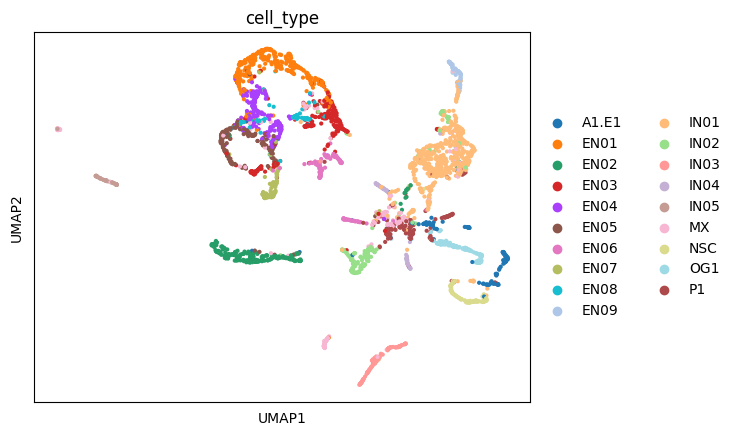

In [13]:
adata.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata, use_rep="MultiVI_latent")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color='cell_type', title='cell_type')

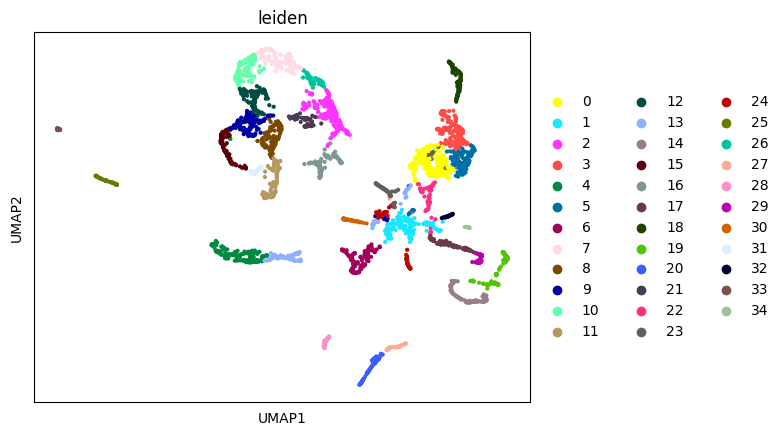

In [14]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden', title='leiden')

In [15]:
calculate_cluster_index(adata)

(0.4096722572573664,
 0.6735728393654856,
 0.6842336148995934,
 0.7652979513710915,
 0.6186979160858888,
 0.6842336148995936)